# 👽👾 `print(fiction)` 📚🛸

> #### A data science project by _Tobias Reaper_

#### 📓 Notebook 3: Modeling 🧠

---

### Notebook Outline

[explanation of this notebook in context of project]

* Intro
* Imports and Configuration

---

## Introduction

`print(fiction)` is a solo project I worked on to explore the data on and around stories—specifically, the stories contained in print books.

I used Scrapy to scrape metadata for over 20,000 books from GoodReads and used it to train a gradient-boosted random forest classifier. The final version of the model classified books as either fiction or nonfiction with 88% accuracy.

The dataset is freely available for download from GitHub or Kaggle (link to come).
I built an interactive dashboard using Plotly Dash that can be used to tinker with the model parameters and view the resulting prediction in real time.

You can find the current live version of the app here: [print(fiction)](http://print-fiction.herokuapp.com/)

The notebooks detailing the entire process of data gathering, wrangling, modeling, and deployment, can be found here: [print(fiction) notebooks](https://github.com/tobias-fyi/print-fiction/tree/master/notebooks)

---

### Imports and Configuration

⚙️📥 

In [1]:
# === General Imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

In [2]:
# === Configure === #
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [3]:
%%capture
!pip install category-encoders
!pip install eli5

In [4]:
# === ML Imports === #

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Model validation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Interpretations
import eli5
from eli5.sklearn import PermutationImportance

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


---

## 📈 Load Data

In [5]:
# === Load the dataset === #
# This version was exported from the previous notebook
# after doing some initial wrangling
data_path = "https://raw.githubusercontent.com/tobias-fyi/vela/master/ds/interview_prep/practice/print-fiction/assets/must_read_books-02.csv"

books = pd.read_csv(data_path, na_values="?")
print(books.shape)
books.head(3)

(18344, 18)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0,1
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,0,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0,1
2,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1,477.0,1521.0,9016.0,25447.0,47472.0,1974.0,1.0,1.0,1,1


In [6]:
# === Confirm null values were read in correctly === #
books.isnull().sum()

title                0
author               0
num_ratings          0
num_reviews          0
avg_rating           0
num_pages          666
language          1332
series               0
1_rating_count      83
2_rating_count      83
3_rating_count      83
4_rating_count      83
5_rating_count      83
publish_year       282
publish_month      282
publish_day        282
fiction              0
republish            0
dtype: int64

---

## Model validation

* Split data into train, validation, and test sets
* Choose an appropriate evaluation metric
* Get a baseline accuracy (or precision/recall)

In [7]:
# === Split data into train / val / test === #
train, test = train_test_split(books, stratify=books["fiction"], test_size=0.2, random_state=92)
train, val = train_test_split(train, stratify=train["fiction"], test_size=0.2, random_state=92)

train.shape, val.shape, test.shape

((11740, 18), (2935, 18), (3669, 18))

In [8]:
# === Set up target and features === #
target = "fiction"

# Arrange y vector
y_train = train[target]
y_val = val[target]
y_test = test[target]

print(y_train.shape, y_val.shape, y_test.shape)

# Arrange X matrices
X_train = train.drop(columns=[target])
X_val = val.drop(columns=[target])
X_test = test.drop(columns=[target])

print(X_train.shape, X_val.shape, X_test.shape)

(11740,) (2935,) (3669,)
(11740, 17) (2935, 17) (3669, 17)


1    6145
0    5595
Name: fiction, dtype: int64


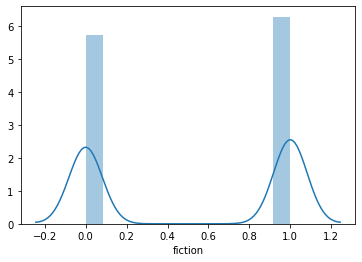

In [9]:
# === Target distribution === #
print(y_train.value_counts())
sns.distplot(y_train);

#### Majority class baseline

In [10]:
# === Use mode as predictions === #
maj = y_train.mode()[0]  # Mode is 1 (fiction)

# Simply predict 1 for every training example
y_pred_maj = [maj] * len(y_train)

# Baseline accuracy
accuracy_score(y_train, y_pred_maj)

0.5234241908006815

#### Limited logistic baseline

In [11]:
# === Use only a few features for this baseline === #
base_features = [
    "num_reviews",
    "avg_rating",
    "num_pages",
]

# Arrange X matrices
X1_train = train[base_features]
X1_val = val[base_features]
X1_test = test[base_features]

X1_train.shape, X1_val.shape, X1_test.shape

((11740, 3), (2935, 3), (3669, 3))

In [12]:
# === Baseline model === #
pipe1 = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ("logreg", LogisticRegression(random_state=92)),
])

# Train base pipeline
pipe1.fit(X1_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('logreg', LogisticRegression(random_state=92))])

In [13]:
# === Made predictions to get validation accuracy === #
y_pred1 = pipe1.predict(X1_val)

# Compute accuracy
print("Baseline accuracy:", accuracy_score(y_val, y_pred1))

Baseline accuracy: 0.6275979557069846


In [14]:
# === Baseline confusion matrix === #
confusion_matrix(y_val, y_pred1)

array([[ 821,  578],
       [ 515, 1021]])

#### Default Random Forest

In [15]:
# === Default random forest model === #
def_drop_columns = [
    "title",
    "author",
    "language",
]

X2_train = X_train.drop(columns=def_drop_columns)
X2_val = X_val.drop(columns=def_drop_columns)
X2_test = X_test.drop(columns=def_drop_columns)

rf1_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf1_pipe.fit(X2_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf1 = rf1_pipe.predict(X2_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf1))
print("  F1 score:", f1_score(y_val, y_pred_rf1))

Default random forest eval metrics:
  Accuracy: 0.7342419080068143
  F1 score: 0.7477360931435963


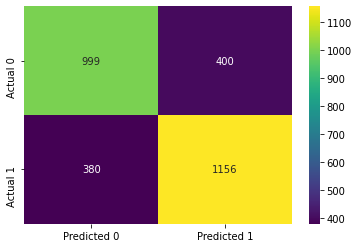

In [16]:
# === Evaluate default rf with confusion matrix === #
from sklearn.utils.multiclass import unique_labels

unique_labels(y_val)  # Create unique labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

# Plot the confusion matrix
plot_confusion_matrix(y_val, y_pred_rf1);

Alrighty then! With the (almost) full set of features and default hyperparameters the target can be predicted with ~73% accuracy. Although the target is not skewed very much, it is still skewed. Therefore, accuracy may not be the best way to evaluate the model. A better metric could be the F1 score. This is a little higher than the accuracy, clocking in at almost 75%.

The F1 score is made up of the precision and recall. Actually, it can be interpreted of as the weighted average of precision and recall.

This provides a better method of evaluating performance, because it takes into account false positives and false negatives. Accuracy only accounts for the model's correct predictions and mistakes, irrespective of _how_ the model made those mistakes.

In [17]:
# === Calculate precision === #
true_pos = 1156
false_pos = 400
precision = true_pos / (true_pos + false_pos)
print(f"Precision: {precision}")

Precision: 0.7429305912596401


In [18]:
# === Calculate recall === #
true_pos = 1156
false_neg = 380
precision = true_pos / (true_pos + false_neg)
print(f"Precision: {precision}")

Precision: 0.7526041666666666


In [19]:
# === Classification report === #
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1399
           1       0.74      0.75      0.75      1536

    accuracy                           0.73      2935
   macro avg       0.73      0.73      0.73      2935
weighted avg       0.73      0.73      0.73      2935



Let's see what we can do to increase that score.

---

## Iterate

* [x] Engineer new features
* [x] Feature pruning with permutation importance
* [x] Use cross-validation (RandomizedSearchCV) to tune hyperparameters
* [x] Try out different algorithms
  * [x] KNearestClassifier
  * [x] XGBClassifier

### Feature Engineering

When I initially started this project, I went through the process of validating and training a model or two that tried to predict the average rating of books. This was by far the most common target chosen by those who started Kaggle kernels using other GoodReads datasets. Although this may have the most obvious business value if I was a data scientist working for a book publisher, to me this wasn't a particularly interesting target to try to predict.

I realized this when I hit a wall with my progress in improving the rating-predictor model. One reason was that I did not see any obvious useful features that could be engineered. However, once I found my way to the idea of predicting the fictionality of the books, the target drove the direction I took with my feature engineering. It was a great learning experience for me in engineering features toward the specific target that the model is trying to predict.

Here are the feature ideas I came up with and engineered (all in short succession once the new target was chosen):

- [x] Title begins with "The"
- [x] Has subtitle: contains ":"
- [x] Title character count
- [x] Title word count
- [x] Title longest word
- [x] Author number of names
- [x] Author middle initial
- [x] Ratings (stars) ratio (1 + 2 / 4 + 5)

In [20]:
def engineer_features(data):
    """Engineer a handful of new features."""
    # Create new feature that is if the title begins with "The"
    data["the_title"] = data["title"].str.startswith("The")
    # New feature - has_subtitle
    data["has_subtitle"] = data["title"].str.contains(":")
    # New feature - title character length
    data["title_char_count"] = data["title"].apply(lambda x: len(x))
    # New feature - title word count
    data["title_word_count"] = data["title"].apply(lambda x: len(x.split()))
    # New feature - title longest word
    data["title_longest_word"] = data["title"].apply(lambda x: len(max(x.split(), key=len)))
    # New feature - author number of names
    data["author_name_count"] = data["author"].apply(lambda x: len(x.split()))
    # New feature - author middle initial
    pat = r"\w* (\w. )+ \w*"
    data["author_middle_initial"] = data["author"].str.contains(pat, regex=True)
    # New feature - low/high rating ratio
    data["rating_ratio"] = (data["1_rating_count"] + data["2_rating_count"]) / (data["4_rating_count"] + data["5_rating_count"])
    # Replace Boolean with binary
    data = data.replace(to_replace={True: 1, False:0})
    return data

#### Same random forest with additional features

In [21]:
# === Random forest model, new features === #
X3_train = engineer_features(X_train)
X3_val = engineer_features(X_val)
X3_test = engineer_features(X_test)

rf2_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf2_pipe.fit(X3_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf2 = rf2_pipe.predict(X3_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf2))
print("  F1 score:", f1_score(y_val, y_pred_rf2))

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Default random forest eval metrics:
  Accuracy: 0.7761499148211244
  F1 score: 0.7884057971014492


Got an extra ~5% out of those new features!

And that is with the default RandomForestClassifier hyperparameters and the SimpleImputer. For the next iteration, I will try using the IterativeImputer, then utilize RandomizedSearchCV to tune the hyperparameters and conduct cross-validation.

### Feature Importances

It is likely that some of the features do not help the model make correct predictions. Indeed, some may even be worse than that: they could add noise that makes the model perform worse.

To address this potential problem, I'm going to find the feature importances using a method called permutation importance. Basically, this method will go through each of the features, replacing their data with random noise generated from the distribution of the original data. The performance of the model will be evaluated and compared with the score using all of the original data to find the effect of each feature on the performance of the model.

In [22]:
# === Transformer pipeline === #
# Use the same (fitted) steps from main pipeline
transformers = Pipeline([
    ("encoder", rf2_pipe.named_steps["encoder"]),
    ("imputer", rf2_pipe.named_steps["imputer"]),
])

# Encode and impute
X3_train_transformed = transformers.transform(X3_train)
X3_val_transformed = transformers.transform(X3_val)

In [23]:
# === Instantiate and fit the permuter === #
permuter = PermutationImportance(
    rf2_pipe.named_steps["rfc"], 
    scoring='f1', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X3_val_transformed, y_val)

PermutationImportance(estimator=RandomForestClassifier(random_state=92),
                      random_state=42, scoring='f1')

In [24]:
# === Get permutation importances === #
feature_names = X3_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # Show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0307 ± 0.0021,has_subtitle
0.0264 ± 0.0116,avg_rating
0.0197 ± 0.0066,4_rating_count
0.0193 ± 0.0031,publish_year
0.0153 ± 0.0059,num_ratings
0.0124 ± 0.0039,series
0.0116 ± 0.0071,1_rating_count
0.0096 ± 0.0048,num_pages
0.0078 ± 0.0099,num_reviews
0.0073 ± 0.0091,3_rating_count


Based on the above table, I should see either no change or a small increase in the model's performance by removing `publish_month` and `author_middle_initial`. I'm going to try removing those and training the model again.

As for the rest of the features, I find it interesting to see what features have the largest positive effect on the model's predictive power. From this table, I can see that the majority of the benefit I got from engineering the new features came from the `has_subtitle` feature. This feature, according to the permutation importance table, is the most important predictor by quite a long shot and accounted for 0.04 simply indicates whether the title of the book has a colon in it. My intuition was that having a subtitle is very common for nonfiction books, not so much for fiction.

One other engineered feature that seems to be a good predictor is `title_char_count`, or title character count

In [25]:
# === Random forest model, new features === #
more_drop_cols = [
    "author_middle_initial",
    "publish_month",
]

# New features are already engineered
X4_train = X3_train.drop(columns=more_drop_cols)
X4_val   = X3_val.drop(columns=more_drop_cols)
X4_test  = X3_test.drop(columns=more_drop_cols)

rf3_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf3_pipe.fit(X4_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf3 = rf3_pipe.predict(X4_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf3))
print("  F1 score:", f1_score(y_val, y_pred_rf3))

Default random forest eval metrics:
  Accuracy: 0.7839863713798978
  F1 score: 0.7965340179717587


It seems that removing the features indicated to have negative or no feature importance actually had a small negative effect on the model's performance. That result in hand, I'm going to leave those features in the model.

In [26]:
# === How does it perform on the test data? === #
y_pred_test_rf2 = rf2_pipe.predict(X3_test)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_test, y_pred_test_rf2))
print("  F1 score:", f1_score(y_test, y_pred_test_rf2))

Default random forest eval metrics:
  Accuracy: 0.7647860452439357
  F1 score: 0.7783200616491139


### Cross-validation + Hyperparameter tuning

In [27]:
# === Engineer the new features === #
# Start from original dataset, because data
# will only be split into train and test
books2 = engineer_features(books)

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [28]:
# === Take a look === #
print(books2.shape)
books2.head(2)

(18344, 26)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish,the_title,has_subtitle,title_char_count,title_word_count,title_longest_word,author_name_count,author_middle_initial,rating_ratio
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0,1,1,1,53,9,9,1,0,0.174301
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,0,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0,1,1,0,10,2,6,2,0,0.150773


In [29]:
# === Split data into train / test === #
train, test = train_test_split(books2, stratify=books2["fiction"], test_size=0.2, random_state=92)

train.shape, test.shape

((14675, 26), (3669, 26))

In [46]:
# === Set up target and features === #
# No val this time bc using cross-validation
target = "fiction"

drop_cols = [  # Columns not useful to model
    "title",
    "author",
    "language",
#     "publish_month",
    "publish_day",
    "author_middle_initial",
]

# Arrange y vector
y_train = train[target]
y_test = test[target]

print(y_train.shape, y_test.shape)

# Arrange X matrices
X_train = train.drop(columns=[target] + drop_cols)
X_test = test.drop(columns=[target] + drop_cols)

print(X_train.shape, X_test.shape)

(14675,) (3669,)
(14675, 20) (3669, 20)


In [47]:
# === Random forest, Part 3 === #
# Tune hyperparameters using cross-validation

rf3_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", IterativeImputer(random_state=92)),
    ("rfc", RandomForestClassifier(random_state=92)),
])

rf3_params = {
    "imputer__initial_strategy": ["median", "most_frequent"], 
    "imputer__max_iter": randint(16, 40),
    "imputer__tol": uniform(0.001, 0.05),
    "imputer__n_nearest_features": randint(2, 10),
    "imputer__imputation_order": ["ascending", "roman", "random"],
    "rfc__n_estimators": randint(80, 300), 
    "rfc__max_depth": randint(6, 32),
    "rfc__min_samples_split": uniform(0, 1), 
}

# Define the search using parameter distros above
rf3_search = RandomizedSearchCV(
    rf3_pipe, 
    param_distributions=rf3_params, 
    n_iter=5,
    cv=5, 
    scoring='f1',
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1,
    random_state=92,
)

# Train default random forest
rf3_search.fit(X_train, y_train)

# Best combination of hyperparameters and their resulting f1 score
print("Best hyperparameters", rf3_search.best_params_)
print("F1 score", rf3_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   18.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   20.0s finished


Best hyperparameters {'imputer__imputation_order': 'random', 'imputer__initial_strategy': 'median', 'imputer__max_iter': 19, 'imputer__n_nearest_features': 4, 'imputer__tol': 0.02223640657375538, 'rfc__max_depth': 21, 'rfc__min_samples_split': 0.00799211859966853, 'rfc__n_estimators': 205}
F1 score 0.7849781869334655


That score is actually not as good as the default random forest was, without cross-validation. It could also be that the best estimator from this search would outperform the previous one when predicting the test data. Or, it could be that the parameters and their ranges I'm searching are not optimal.

Another reason could be that I simply did not provide enough of a search window. That is, I could try increasing the number of iterations that the search goes through while testing out parameter combinations.

That score is still pretty close though. I'm going to try out some other algorithms now, starting with nearest neighbors.

### Nearest Neighbors

Nearest neighbors model with KNeighborsClassifier algorithm.

In [48]:
# === Nearest Neighbors === #

nn_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", IterativeImputer(random_state=92)),
    ("nn", KNeighborsClassifier()),
])

nn_params = {
    "imputer__initial_strategy": ["median", "most_frequent"], 
    "imputer__max_iter": randint(16, 40),
    "imputer__tol": uniform(0.001, 0.05),
    "imputer__n_nearest_features": randint(2, 10),
    "imputer__imputation_order": ["ascending", "roman", "random"],
    "nn__n_neighbors": randint(2, 20), 
    "nn__weights": ["uniform", "distance"],
    "nn__algorithm": ["ball_tree", "kd_tree"],
    "nn__leaf_size": randint(20, 50),
}

# Define the search using parameter distros above
nn_search = RandomizedSearchCV(
    nn_pipe, 
    param_distributions=nn_params, 
    n_iter=5,
    cv=5, 
    scoring="f1",
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1,
    random_state=92,
)

# Train default random forest
nn_search.fit(X_train, y_train)

# Best combination of hyperparameters and their resulting f1 score
print("Best hyperparameters", nn_search.best_params_)
print("F1 score", nn_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   15.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.5s finished


Best hyperparameters {'imputer__imputation_order': 'roman', 'imputer__initial_strategy': 'median', 'imputer__max_iter': 27, 'imputer__n_nearest_features': 7, 'imputer__tol': 0.015464012740496254, 'nn__algorithm': 'ball_tree', 'nn__leaf_size': 47, 'nn__n_neighbors': 19, 'nn__weights': 'uniform'}
F1 score 0.697427625975729


It seems that Random Forest is quite a bit better of an algorithm for this problem than k-nearest neighbors. Therefore, I won't be moving forward with nearest neighbors.

The last algorithm I'll try is a gradient-boosted decision tree classifier from XGBoost: `XGBClassifier`.

### Gradient Boosting

Training a gradient-boosted decision tree using [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

Though I don't have a record of every single iteration of the below classifier search, the method I used to tune is to basically look at the values of each parameter, and moved the search range to more closely fit around those values.

I was surprised to find that my initial attempts at training the `XGBClassifier` had about the same performance as the default random forest with the newly-engineered features.

As I mentioned above, one hypothesis of what was causing the discrepancy (or lack thereof: I assumed gradient-boosting would increase the performance, which maybe wasn't a sound assumption), could be the simple fact that the randomized search doesn't cover every possibility. To test this, I increased the number of iterations and let 'er rip!

In [31]:
# === XGBoost Classifier === #
from xgboost import XGBClassifier

xgb1_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", IterativeImputer(random_state=92)),
    ("xgb", XGBClassifier(random_state=92)),
])

xgb1_params = {
    "imputer__initial_strategy": ["median", "most_frequent"], 
    "imputer__max_iter": randint(16, 45),
    "imputer__tol": uniform(0.02, 0.04),
    "imputer__n_nearest_features": randint(2, 10),
    "imputer__imputation_order": ["ascending", "roman", "random"],
    "xgb__n_estimators": randint(80, 160), 
    "xgb__max_depth": randint(18, 48),
    "xgb__learning_rate": uniform(0.05, .5),
}

# Define the search using parameter distros above
xgb1_search = RandomizedSearchCV(
    xgb1_pipe, 
    param_distributions=xgb1_params, 
    n_iter=10,
    cv=4,
    scoring="f1",
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1,
    random_state=92,
)

# Train default random forest
xgb1_search.fit(X_train, y_train)

# Best combination of hyperparameters and their resulting f1 score
print("F1 score", xgb1_search.best_score_)
print("Best hyperparameters:")
for param, val in xgb1_search.best_params_.items():
    print(  f"{param}: {val}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.6min finished


F1 score 0.7942245127829319
Best hyperparameters:
imputer__imputation_order: ascending
imputer__initial_strategy: median
imputer__max_iter: 31
imputer__n_nearest_features: 3
imputer__tol: 0.03492326452711587
xgb__learning_rate: 0.10726406674881385
xgb__max_depth: 27
xgb__n_estimators: 100


### More Random Forests

Even with 40 total fits (4 cross-validation folds, 10 iterations) the gradient-boosted classifier did not really outperform the random forest by any significant margin. Given the additional complexity and computation required for an XGBoost model, I'm going to use the random forest classifier instead.

To continue testing the hypothesis that my initial number of iterations was too low for the search to converge on a good combination of hyperparameters, I'm going to train more random forests. This time, I'm going to try running the random search with a higher number of iterations. If that seems promising, I'm going to further tune the hyperparameters and look into any additional hyperparameters that might be good to include in the tuning process.

In [49]:
# === Random forest, Part 4 === #
rf4_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", IterativeImputer(random_state=92, n_nearest_features=3)),
    ("rfc", RandomForestClassifier(random_state=92)),
])

rf4_params = {
    "imputer__initial_strategy": ["median", "most_frequent"], 
    "imputer__max_iter": randint(8, 20),
    "imputer__tol": uniform(0.01, 0.04),
    "imputer__imputation_order": ["ascending", "roman", "random"],
    "rfc__n_estimators": randint(140, 200), 
    "rfc__max_depth": randint(6, 18),
    "rfc__min_samples_split": randint(6, 14), 
    "rfc__min_impurity_decrease": uniform(0, .01), 
}

# Define the search using parameter distros above
rf4_search = RandomizedSearchCV(
    rf4_pipe, 
    param_distributions=rf4_params, 
    n_iter=15,
    cv=5, 
    scoring='f1',
    verbose=10,
    return_train_score=True, 
    n_jobs=-1,
    random_state=92,
)

# Train default random forest
rf4_search.fit(X_train, y_train)

# Best combination of hyperparameters and their resulting f1 score
print('F1 score', rf4_search.best_score_)
print('Best hyperparameters:')
for param, val in rf4_search.best_params_.items():
    print(  f"{param}: {val}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   59.1s finished


F1 score 0.7897015809090806
Best hyperparameters:
imputer__imputation_order: ascending
imputer__initial_strategy: median
imputer__max_iter: 12
imputer__tol: 0.029121541514263292
rfc__max_depth: 12
rfc__min_impurity_decrease: 0.00010629484293753989
rfc__min_samples_split: 11
rfc__n_estimators: 195


In [50]:
# === How does it perform on the test data? === #
y_pred_test_rf4 = rf4_search.predict(X_test)

# Compute evaluation metrics
print("Random forest 4 eval metrics:")
print("  Accuracy:", accuracy_score(y_test, y_pred_test_rf4))
print("  F1 score:", f1_score(y_test, y_pred_test_rf4))

Random forest 4 eval metrics:
  Accuracy: 0.7639683837557918
  F1 score: 0.7825213460572576


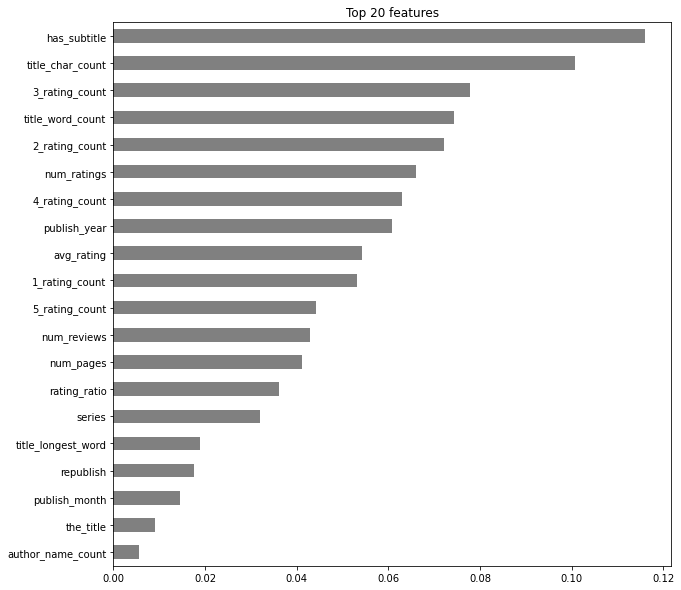

In [51]:
# === Get feature importances === #
rf4 = rf4_search.best_estimator_["rfc"]
importances = pd.Series(rf4.feature_importances_, X_train.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

---

## Results and Interpretation

I tried many different combinations of different hyperparameters and the best F1 score I was able to achieve was just north of .79. Even with all of my tuning, I never beat the F1 score that was achieved with the random forest classifier using default hyperparameters.

One final step to be taken before deployment is to inspect the predictions that the model made on the test set, looking at the predicted probabilities that resulted in each of the predictions. By looking at the predicted probabilities, I can look at instances when the model was sure or unsure of its predictions, and if those predictions were correct or not.

This can provide some insight into the reasons for the model being incorrect, which could be valuable information to have, particularly when attempting to interpret (the results of) the model.

In [ ]:
# === Title and indexes to match with pred_proba === #
title_id_train = X_train.reset_index()[["index", "title"]]
title_id_test = X_test.reset_index()[["index", "title"]]

In [52]:
# Get indexes as an id field to match up on later
train_id = X_train.reset_index()["index"]
test_id = X_test.reset_index()["index"]

In [53]:
test_id.head()

0     1042
1    10779
2    10072
3    15540
4    13007
Name: index, dtype: int64

In [57]:
# === ROC AUC + predicted probabilities === #
from sklearn.metrics import roc_auc_score

# Process the test data
transformers_2 = Pipeline([
    ("encoder", rf4_search.best_estimator_["encoder"]),
    ("imputer", rf4_search.best_estimator_["imputer"]),
])

# Encode and impute
X_test_transform = transformers_2.transform(X_test)
class_index = 1

# Make predictions with the trained gradient boosted classifier
y_pred_proba_rf4 = rf4_search.predict_proba(X_test_transform)[:, class_index]

# ROC AUC score ranges from 0-1; higher is better
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba_rf4))

Test ROC AUC for class 1:
0.8461619555985452


#### Predicted probabilities

In [58]:
# === Reset index of test set to get column to match on === #
X_test = X_test.reset_index()
X_test.head()

,index,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,republish,the_title,has_subtitle,title_char_count,title_word_count,title_longest_word,author_name_count,rating_ratio
0,1042,112871.0,4674.0,4.00,317.0,0,1593.0,5439.0,24255.0,41993.0,39591.0,1997.0,9.0,1,0,0,29,6,7,2,0.086193
1,10779,364.0,47.0,3.97,431.0,0,12.0,16.0,72.0,134.0,130.0,2016.0,5.0,1,0,0,18,3,8,2,0.106061
2,10072,49.0,12.0,4.18,294.0,0,0.0,3.0,10.0,11.0,25.0,1994.0,6.0,0,0,0,16,3,8,2,0.083333
3,15540,150.0,14.0,3.87,200.0,1,0.0,2.0,46.0,71.0,31.0,1994.0,9.0,0,0,0,16,3,6,2,0.019608
4,13007,19322.0,213.0,4.09,268.0,1,285.0,986.0,3758.0,5984.0,8309.0,1993.0,9.0,1,0,1,40,6,11,2,0.088925


In [59]:
X_test.shape, test_id.shape, y_pred_proba_rf4.shape, y_test.shape

((3669, 21), (3669,), (3669,), (3669,))

In [60]:
y_test.reset_index().head()

,index,fiction
0,1042,1
1,10779,0
2,10072,0
3,15540,1
4,13007,1


In [62]:
# === Compare true / pred === #

# Create new dataframe to compare the predictions to the actual
df = pd.DataFrame({
    'index': test_id,
    'pred_proba': y_pred_proba_rf4,
})

print(df.shape)
df.head()

(3669, 2)


,index,pred_proba
0,1042,0.911425
1,10779,0.511888
2,10072,0.192328
3,15540,0.552947
4,13007,0.550052


In [63]:
df = df.merge(y_test.reset_index())

print(df.shape)
df.head()

(3669, 3)


,index,pred_proba,fiction
0,1042,0.911425,1
1,10779,0.511888,0
2,10072,0.192328,0
3,15540,0.552947,1
4,13007,0.550052,1


In [64]:
# === Merge the rest of the features back in === #
df = df.merge(
     X_test,
     how='left'
)

print(df.shape)
df.head()

(3669, 23)


,index,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,republish,the_title,has_subtitle,title_char_count,title_word_count,title_longest_word,author_name_count,rating_ratio
0,1042,0.911425,1,112871.0,4674.0,4.00,317.0,0,1593.0,5439.0,24255.0,41993.0,39591.0,1997.0,9.0,1,0,0,29,6,7,2,0.086193
1,10779,0.511888,0,364.0,47.0,3.97,431.0,0,12.0,16.0,72.0,134.0,130.0,2016.0,5.0,1,0,0,18,3,8,2,0.106061
2,10072,0.192328,0,49.0,12.0,4.18,294.0,0,0.0,3.0,10.0,11.0,25.0,1994.0,6.0,0,0,0,16,3,8,2,0.083333
3,15540,0.552947,1,150.0,14.0,3.87,200.0,1,0.0,2.0,46.0,71.0,31.0,1994.0,9.0,0,0,0,16,3,6,2,0.019608
4,13007,0.550052,1,19322.0,213.0,4.09,268.0,1,285.0,986.0,3758.0,5984.0,8309.0,1993.0,9.0,1,0,1,40,6,11,2,0.088925


In [125]:
# === Merge the titles back in === #
df = df.merge(
     title_id_test,
     how='left'
)

print(df.shape)
df.head()

(3625, 27)


,index,pred_proba,fiction,author,num_ratings,num_reviews,avg_rating,num_pages,language,short_stories,publish_year,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,in_series,has_charlist,has_setting,char_x_setting,the_title,has_subtitle,title_char_count,title_word_count,author_name_count,rating_ratio_1_5,title
0,7999,0.994971,1,John Connolly,4085.0,243.0,3.97,451.0,English,0,2005.0,61.0,186.0,891.0,1643.0,1304.0,0,1,1,1,0,0,7,2,2,0.083814,Bad Men
1,16674,0.231404,0,Mila Gray,7054.0,925.0,4.19,373.0,English,0,2014.0,121.0,257.0,1091.0,2294.0,3291.0,1,0,0,0,0,0,15,4,2,0.067681,Come Back to Me
2,2684,0.000045,0,Gene Baur,1318.0,129.0,4.29,320.0,English,0,2008.0,16.0,41.0,164.0,416.0,681.0,0,0,0,0,0,1,64,10,2,0.051960,Farm Sanctuary: Changing Hearts and Minds Abou...
3,11632,0.994077,1,J. Bernlef,7718.0,305.0,3.87,160.0,Dutch,0,1985.0,103.0,381.0,1820.0,3534.0,1880.0,0,1,1,1,0,0,14,1,2,0.089398,Hersenschimmen
4,12886,0.885394,0,Shannon Morton,264.0,30.0,3.59,226.0,English,0,2012.0,18.0,30.0,64.0,83.0,69.0,1,0,0,0,0,0,15,3,2,0.315789,Tempted by Evil
